In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sympy import *
from gplearn.genetic import SymbolicRegressor
from gplearn.fitness import make_fitness

In [2]:
converter = {
'sub': lambda x, y : x - y,
'div': lambda x, y : x/y,
'mul': lambda x, y : x*y,
'add': lambda x, y : x + y,
'neg': lambda x    : -x,
'pow': lambda x, y : x**y,
'sin': lambda x    : sin(x),
'cos': lambda x    : cos(x),
'inv': lambda x: 1/x,
'sqrt': lambda x: x**0.5,
'pow3': lambda x: x**3,
}

## Import data

In [3]:
data_raw = pd.read_csv('data/RESSPECT_PERFECT_LIGHTCURVE.csv')
meta_raw = pd.read_csv('data/RESSPECT_PERFECT_HEAD.csv')

all_obj = np.unique(data_raw['SNID'])


In [15]:
meta_raw[meta_raw['SNID']==74]
all_obj[36]

74.0

In [16]:
all_obj = np.unique(data_raw['SNID'])

# Normalize flux 
maxtable = data_raw.pivot_table(index="FLT", columns="SNID", values="FLUXCAL",aggfunc='max')
maxdf = pd.DataFrame(data=maxtable.unstack())
clean = pd.merge(maxdf, data_raw, on=["SNID","FLT"])
clean["FLUXCAL"] = clean["FLUXCAL"]/clean[0]
clean["FLUXCALERR"] = clean["FLUXCALERR"] / clean[0]
clean = clean.drop([0],axis=1)

# Shift mjd
mintable = clean.pivot_table(index="FLT", columns="SNID", values="MJD",aggfunc='min')
mindf = pd.DataFrame(data=mintable.unstack())
clean = pd.merge(mindf, clean, on=["SNID","FLT"])
clean["MJD"] = clean["MJD"]-clean[0]
clean = clean.drop([0],axis=1)

# Normalize mjd
maxtable = clean.pivot_table(index="FLT", columns="SNID", values="MJD",aggfunc='max')
maxdf = pd.DataFrame(data=maxtable.unstack())
clean = pd.merge(maxdf, clean, on=["SNID","FLT"])
clean["MJD"] = clean["MJD"]/clean[0]
clean = clean.drop([0],axis=1)

clean

,SNID,FLT,MJD,FLUXCAL,FLUXCALERR,SNR
0,2.0,Y,0.000000,0.957956,0.003779,253.505750
1,2.0,Y,0.006897,0.987623,0.003825,258.178800
2,2.0,Y,0.013793,0.991227,0.003831,258.741330
3,2.0,Y,0.020690,0.992500,0.003833,258.939730
4,2.0,Y,0.027586,1.000000,0.003845,260.106230
...,...,...,...,...,...,...
2050765,8973.0,z,0.948052,0.031250,0.000676,46.228780
2050766,8973.0,z,0.961039,0.030956,0.000675,45.854053
2050767,8973.0,z,0.974026,0.028360,0.000667,42.502210
2050768,8973.0,z,0.987013,0.028724,0.000668,42.975650


There are 4000 all_obj in the database
For a total of 8 classes :
Iax           800
Ia            800
91bg          800
Ibc_V19       555
II_V19        308
II-NMF        291
Ibc-MOSFIT    245
IIn           201
Name: type, dtype: int64


Text(0.5, 0, 'Redshift')

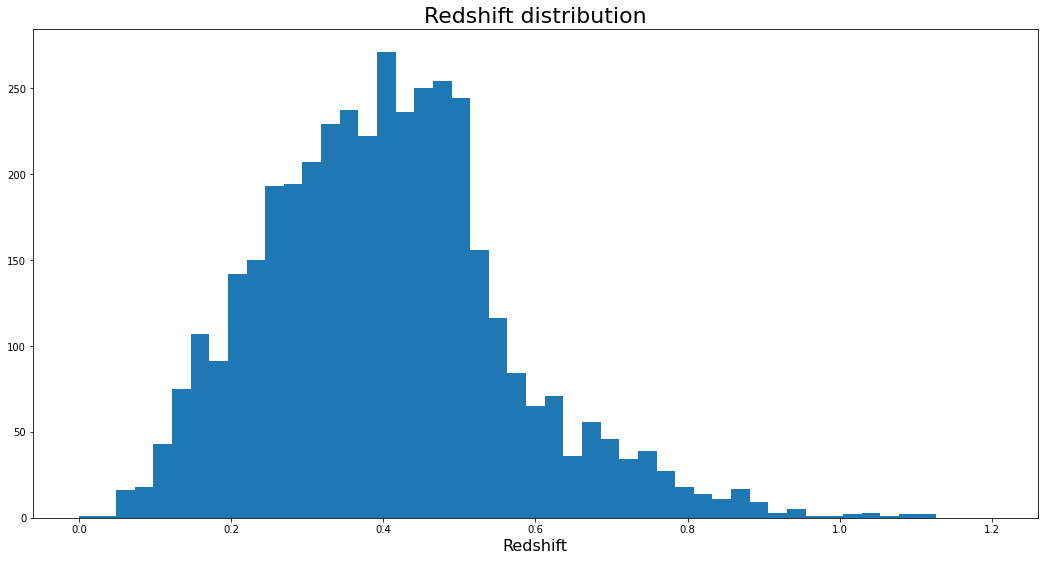

In [17]:
nb_obj = len(meta_raw)
all_type = np.unique(meta_raw['type'])


print('There are %s all_obj in the database\nFor a total of %s classes :\n%s'%(nb_obj,len(all_type),meta_raw['type'].value_counts()))


plt.figure(figsize=(18,9))
plt.hist(meta_raw['redshift'],bins=np.linspace(0,1.2,50));
plt.title('Redshift distribution',size = 22)
plt.xlabel('Redshift',size = 16)



## Visualise a specific object

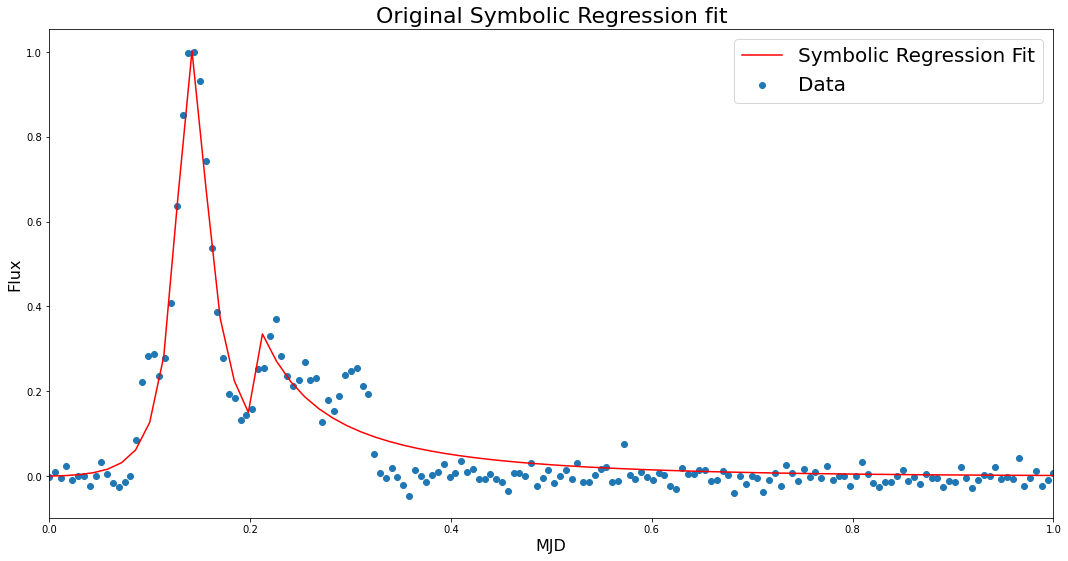

In [142]:


obj = all_obj[36]
band = 'u'

#[22:50]

mask = (clean['SNID'] == obj) & (clean['FLT'] == band)
flux = (clean.loc[mask,'FLUXCAL']).reset_index(drop=True)
mjd = (clean.loc[mask,'MJD']).reset_index(drop=True)
fluxerr = (clean.loc[mask,'FLUXCALERR']).reset_index(drop=True)

mjd = mjd.append(pd.Series([-1,-2,-3,2,3,4]),ignore_index=True)
flux = flux.append(pd.Series([0,0,0,0,0,0]),ignore_index=True)
fluxerr = fluxerr.append(pd.Series([0.001]*6),ignore_index=True)

plt.figure(figsize=(18,9))
plt.scatter(mjd,flux,label='Data')
plt.plot(x_fit,_ego(x_fit,*guess_ego),c='red',label='Symbolic Regression Fit')

plt.title('Original Symbolic Regression fit',size = 22)
plt.xlabel('MJD',size = 16)
plt.ylabel('Flux',size = 16)
plt.xlim(0,1)
plt.legend(fontsize = 20)

## Fit using genetic regression

In [129]:
from gplearn.functions import make_function

def _protected_exponent(x1):
    with np.errstate(over='ignore'):
        return np.where(np.abs(x1) < 10, np.exp(x1), np.exp(10))
    
    
protected_exponent = make_function(function=_protected_exponent,
                        name='exp', arity=1)

def _bazin(x,p1,p2,p3,p4,p5):
    with np.errstate(over='ignore'):
        
        p3 =  np.where(p3 != 0, p3, sign(p3)*0.001)
        p4 =  np.where(p4 != 0, p4, sign(p4)*0.001)
        
        exp1 = _protected_exponent((-(x-p2)/p3).astype(float))
        exp2 = _protected_exponent(((x-p2)/p4).astype(float))

        
        return p1*exp1/exp2 + p5
    
    
bazin = make_function(function=_bazin,
                        name='baz', arity=6)

def _step(x1):
    return np.where(x1 > 0, x1, 0)
    
    
step = make_function(function=_step,
                        name='step', arity=1)

def _step2(x, p1, p2):
    
    protex = np.where(abs(x) > 0.001, x, (np.sign(x)+0.00001)*0.001)
    x1 = (p1*x-p2)/protex
    
    return np.where(x1 > 0, x1, 0)
    
    
step2 = make_function(function=_step2,
                        name='step2', arity=3)


In [130]:
def _mape(y, y_pred, w):
    
    diffs = (np.abs(y - y_pred))**2
    return 100. * np.average(diffs, weights=w)

mape = make_fitness(_mape, greater_is_better=False)

population_size=600
generations=200
parsimony_coefficient = 0.0001
verbose = 1

p_crossover=0.25
p_subtree_mutation=0.15
p_hoist_mutation=0.30
p_point_mutation=0.30

tournament_size=10

function_set = ['add', 'sub','mul', 'div',protected_exponent,step]#,protected_exponent,step,'inv','neg'], 'mul', 'div',,bazin,step2

In [15]:
gp = SymbolicRegressor(population_size=population_size,function_set=function_set,
                       generations=generations,parsimony_coefficient=parsimony_coefficient,
                       random_state=42,verbose=verbose,metric=mape,p_crossover=p_crossover,
                      p_subtree_mutation=p_subtree_mutation,p_hoist_mutation=p_hoist_mutation,
                      p_point_mutation=p_point_mutation,warm_start=False,stopping_criteria=0.1)
    
gp.fit(pd.DataFrame(data = mjd), flux)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.23      3.26172e+13       27          12.3097              N/A      1.12m
   1    12.39      1.79027e+12       27          12.2221              N/A     58.29s
   2    18.41      1.70069e+08       37          6.10104              N/A      1.01m
   3    26.71      2.86357e+14       43           4.3459              N/A      1.09m
   4    35.57      9.95913e+12       72          3.06025              N/A      1.22m
   5    40.99      2.07831e+09       66          3.04959              N/A      1.34m
   6    44.31      2.96626e+10       37          1.36651              N/A      1.33m
   7    60.15      4.15977e+10       68         0.710617              N/A      1.50m
   8    55.07      1.41991e+14       68         0.710617              N/A  

SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div',
                  generations=200,
                  metric=<gplearn.fitness._Fitness object at 0x7f30d239ef60>,
                  p_crossover=0.25, p_hoist_mutation=0.3, p_point_mutation=0.3,
                  p_subtree_mutation=0.15, parsimony_coefficient=0.0001,
                  population_size=600, random_state=42, stopping_criteria=0.1,
                  verbose=1)

In [51]:
gp.set_params(generations=4000, warm_start=True,parsimony_coefficient = 0.25,
                p_crossover=0.20,
                p_subtree_mutation=0.40,
                p_hoist_mutation=0.20,
                p_point_mutation=0.15)#,function_set = ['add', 'sub','mul', 'div',protected_exponent,step,step2])

gp.fit(pd.DataFrame(data = mjd), flux)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
3000    10.63      4.74621e+09       11         0.744488              N/A     13.64m
3001    10.66      1.26215e+10       11         0.744488              N/A     14.18m
3002    10.80      2.11702e+08       11         0.744488              N/A     13.70m
3003    10.81      1.16575e+07       11         0.744488              N/A     13.71m
3004    10.39      2.70262e+08       11         0.744488              N/A     13.70m
3005    10.61      1.30206e+08       11         0.744488              N/A     13.61m
3006    10.90      3.32257e+09       11         0.744488              N/A     14.11m
3007    10.92      3.73698e+09       11         0.744488              N/A     14.03m
3008    10.54      9.73821e+09       11         0.744488              N/A  

SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div',
                  generations=4000,
                  metric=<gplearn.fitness._Fitness object at 0x7f30d239ef60>,
                  p_crossover=0.2, p_hoist_mutation=0.2, p_point_mutation=0.15,
                  p_subtree_mutation=0.4, parsimony_coefficient=0.25,
                  population_size=600, random_state=42, stopping_criteria=0.1,
                  verbose=1, warm_start=True)

In [52]:
# Print the mathematical equation of the function
sympify((str(gp._program)), locals=converter)

step((0.402 - X0)*(16.1290322580645*X0 + 1.53265266172402))

(-2.0, 1.0)

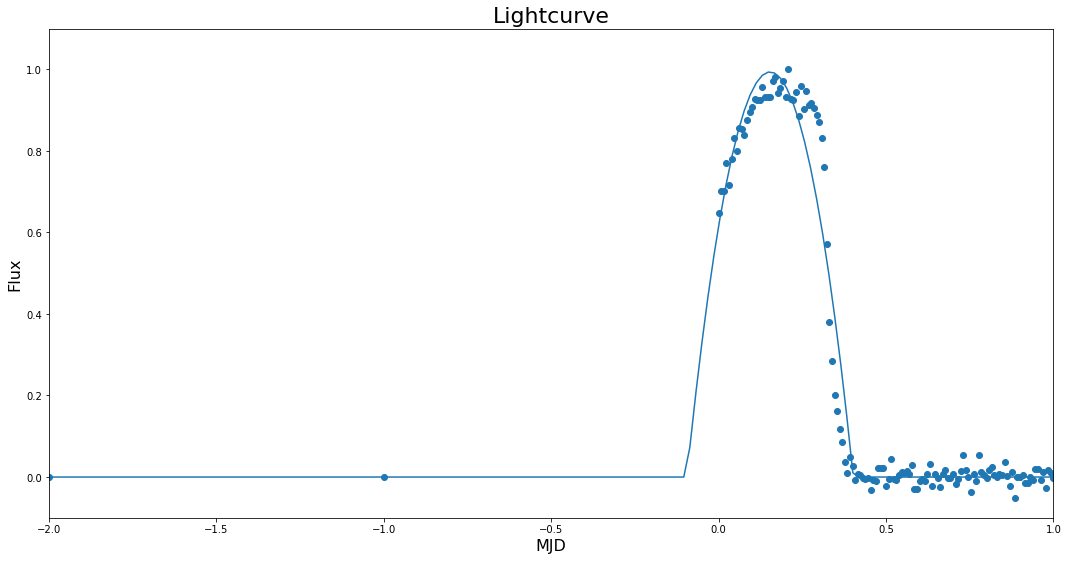

In [54]:
x_fit = np.linspace(mjd.min()-1,mjd.max()+1,500)

plt.figure(figsize=(18,9))
plt.scatter(mjd,flux)
plt.plot(x_fit,gp.predict(pd.DataFrame(data = x_fit)))

plt.title('Lightcurve',size = 22)
plt.xlabel('MJD',size = 16)
plt.ylabel('Flux',size = 16)
plt.ylim(-0.1,1.1)
plt.xlim(-2,1)


In [141]:
from scipy.optimize import least_squares


def _bazin(x,p1,p2,p3,p4,p5):
    with np.errstate(over='ignore'):
        
        p3 =  np.where(p3 != 0, p3, 1)
        p4 =  np.where(p4 != 0, p4, 1)
        
        exp1 = -(x-p2)/p3
        num = np.where(exp1 < 50, np.exp(exp1), np.exp(50))
        
        exp2 = (x-p2)/p4
        den = 1 + np.where(exp2 < 50, np.exp(exp2), np.exp(50))
        
        return p1*num/den + p5

def _bazinSR(x,p1,p2,p3,p4,p5):
    with np.errstate(over='ignore'):
        
        X = x-p2
        P1 = x
        P2 = p3*x
        P3 = p4
        P4 = p5
        P5 = 0
        
        return p1*_bazin(X,P1,P2,P3,P4,P5)

    
def _ego(x,p1,p2,p3,p4,p5,p6,shift):
    
    # DE la forme A / x + B*C*D
    
    x = x+shift+0.13
    
    protex = np.where(abs(x) > 0.001, x, (np.sign(x)+0.00001)*0.001)
    double_expo = 2*x*_protected_exponent(_protected_exponent(x))
    
    den_A = p3 +_protected_exponent(p4*x)
    protec_den_A = np.where(abs(den_A) > 0.001, den_A, (np.sign(den_A)+0.0001)*0.001)
    A = p1 + p2/protec_den_A
    
    B = double_expo - p5
    
    C = double_expo - p6/protex
    
    full_den = x + A*B*C
    protec_full_den = np.where(abs(full_den) > 0.001, full_den, (np.sign(full_den)+0.0001)*0.001)
    
    return _step(x)/protec_full_den

def _bestbaz(x,p1,p2,p3,p4,shift):
    with np.errstate(over='ignore'):
        x = x+shift+0.15
        e = protected_exponent(x)
        return _step(((x+p1)*(p2*x+p3*(x**2)-e)+e)*(x+e+p4))

def bestbaz_err(params, time, flux):
    
    diffs = np.abs(flux - _bestbaz(time,*params))
    return 100. * np.average(diffs)

def ego_err(params, time, flux):
    
    diffs = np.abs(flux - _ego(time,*params))
    return 100. * np.average(diffs)
    

def bazin_err(params, time, flux):
    
    diffs = np.abs(flux - _bazin(time,*params))
    return 100. * np.average(diffs)

def bazinSR_err(params, time, flux):
    
    diffs = np.abs(flux - _bazinSR(time,*params))
    return 100. * np.average(diffs)
     


guess_bazin = [1, mjd[np.argmax(flux)], 0.2, -0.05, 0]
guess_bazinSR = [3.5,  5, -12.5,  1.5, -0.24]
guess_expostep = [0.529,0.879,0.163,5.15,2.87]
guess_ego = [0.865,2.496,0.912,-49.28,0.906,0.125,-mjd[np.argmax(flux)]]
guess_bestbaz = [0.5,4,-13,0.22,-mjd[np.argmax(flux)]]
guess_ego = [0.865,2.496,0.912,-49.28,0.906,0.125,-0.13]


# IMINUIT

(0.0, 1.0)

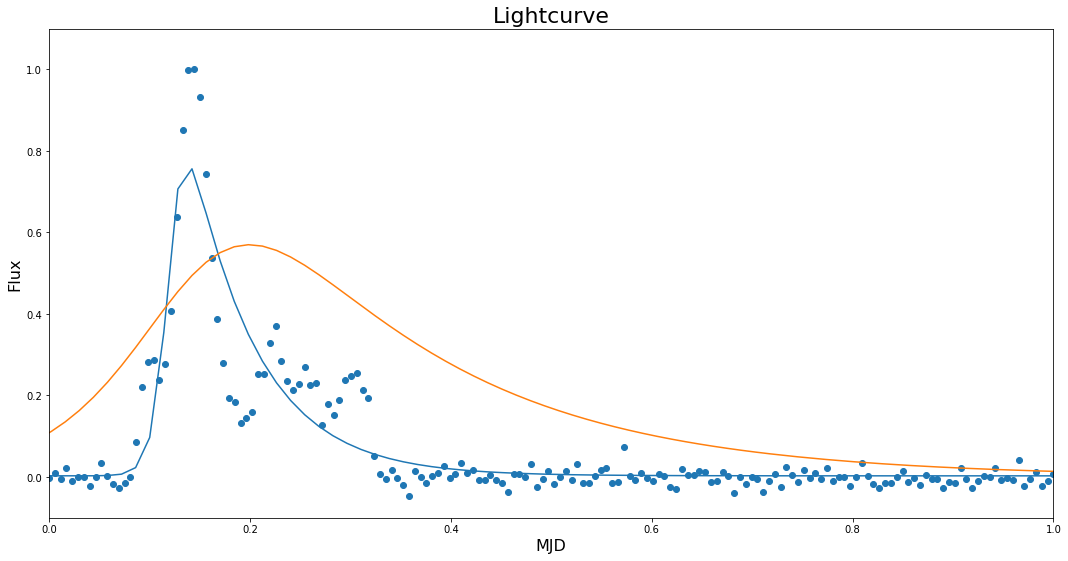

In [135]:
### BAZIN

from iminuit import Minuit
from iminuit.cost import LeastSquares

# iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
# We will revisit how to write this by hand in a later section.
least_squares = LeastSquares(mjd,flux,0.01,_bazin)

m = Minuit(least_squares, p1=guess_bazin[0],p2=guess_bazin[1],p3=guess_bazin[2],p4=guess_bazin[3],p5=guess_bazin[4])  # starting values for α and β

m.migrad()  # finds minimum of least_squares function

x_fit = np.linspace(mjd.min(),mjd.max(),500)

plt.figure(figsize=(18,9))
plt.scatter(mjd,flux)
plt.plot(x_fit,_bazin(x_fit,m.values[0],m.values[1],m.values[2],m.values[3],m.values[4]))
plt.plot(x_fit,_bazin(x_fit,*guess_bazin))


plt.title('Lightcurve',size = 22)
plt.xlabel('MJD',size = 16)
plt.ylabel('Flux',size = 16)
plt.ylim(-0.1,1.1)
plt.xlim(0,1)

(0.0, 1.0)

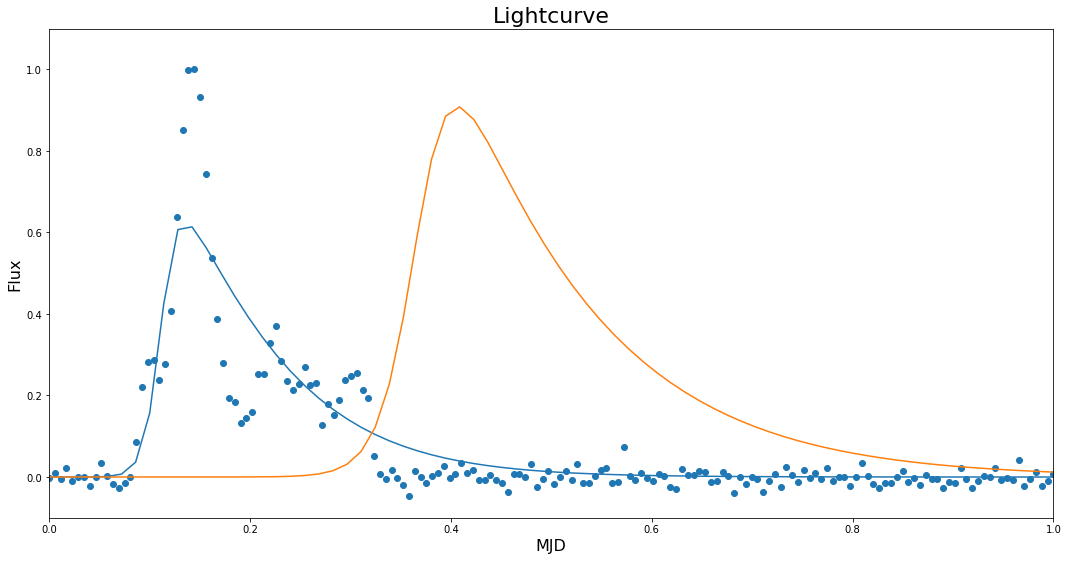

In [136]:
### BAZIN SR

from iminuit import Minuit
from iminuit.cost import LeastSquares

# iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
# We will revisit how to write this by hand in a later section.
least_squares = LeastSquares(mjd,flux,0.01,_bazinSR)

m = Minuit(least_squares, p1=guess_bazinSR[0],p2=guess_bazinSR[1],p3=guess_bazinSR[2],p4=guess_bazinSR[3],p5=guess_bazinSR[4])#,p6=guess[5])  # starting values for α and β

m.migrad()  # finds minimum of least_squares function

x_fit = np.linspace(mjd.min(),mjd.max(),500)

plt.figure(figsize=(18,9))
plt.scatter(mjd,flux)
plt.plot(x_fit,_bazinSR(x_fit,m.values[0],m.values[1],m.values[2],m.values[3],m.values[4]))#,m.values[5]))
plt.plot(x_fit,_bazinSR(x_fit,*guess_bazinSR))


plt.title('Lightcurve',size = 22)
plt.xlabel('MJD',size = 16)
plt.ylabel('Flux',size = 16)
plt.ylim(-0.1,1.1)
plt.xlim(0,1)

(0.0, 1.0)

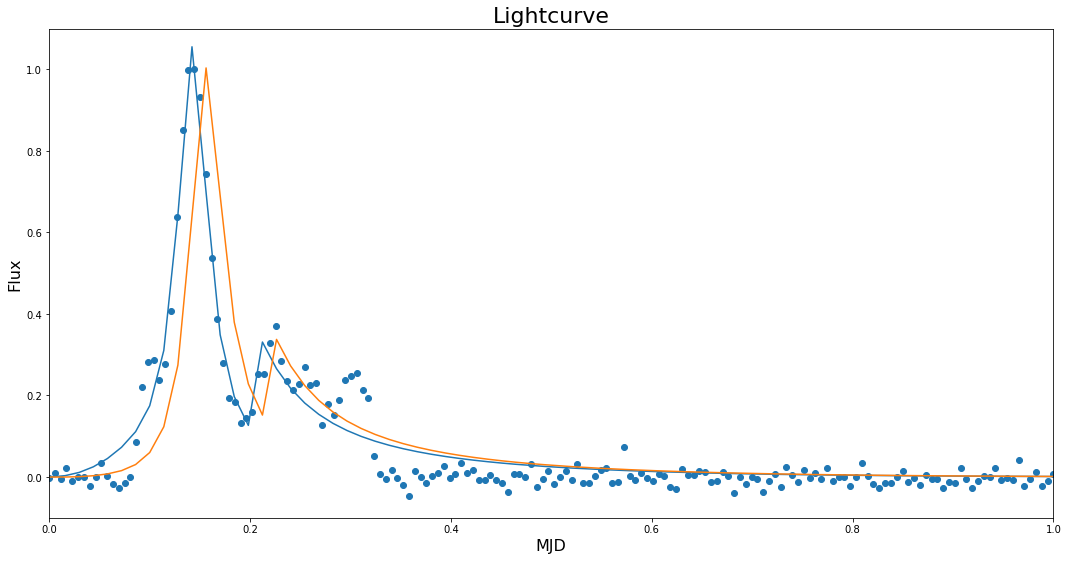

In [137]:
### EGO

from iminuit import Minuit
from iminuit.cost import LeastSquares


least_squares = LeastSquares(mjd,flux,fluxerr,_ego)

m = Minuit(least_squares, p1=guess_ego[0],p2=guess_ego[1],p3=guess_ego[2],p4=guess_ego[3],p5=guess_ego[4],p6=guess_ego[5],shift=guess_ego[6])  # starting values for α and β

m.migrad()  # finds minimum of least_squares function

x_fit = np.linspace(mjd.min(),mjd.max(),500)

plt.figure(figsize=(18,9))
plt.scatter(mjd,flux)
plt.plot(x_fit,_ego(x_fit,m.values[0],m.values[1],m.values[2],m.values[3],m.values[4],m.values[5],m.values[6]))
plt.plot(x_fit,_ego(x_fit,*guess_ego))


plt.title('Lightcurve',size = 22)
plt.xlabel('MJD',size = 16)
plt.ylabel('Flux',size = 16)
plt.ylim(-0.1,1.1)
plt.xlim(0,1)

In [53]:
m.fitarg

{'p1': 0.11158190514410414,
 'p2': -2370.0345490748505,
 'p3': 123430.83707671614,
 'p4': -50.56199840699957,
 'p5': 0.9901430831755765,
 'p6': 0.16960964078733848,
 'shift': -0.30814186988230363,
 'error_p1': 0.0004146467204927895,
 'error_p2': 61.505759805080444,
 'error_p3': 3203.21054852486,
 'error_p4': 0.0672698924655159,
 'error_p5': 0.0077235498234080055,
 'error_p6': 0.002597725537121929,
 'error_shift': 0.0006070879194745643,
 'fix_p1': False,
 'fix_p2': False,
 'fix_p3': False,
 'fix_p4': False,
 'fix_p5': False,
 'fix_p6': False,
 'fix_shift': False,
 'limit_p1': None,
 'limit_p2': None,
 'limit_p3': None,
 'limit_p4': None,
 'limit_p5': None,
 'limit_p6': None,
 'limit_shift': None}

(0.0, 1.0)

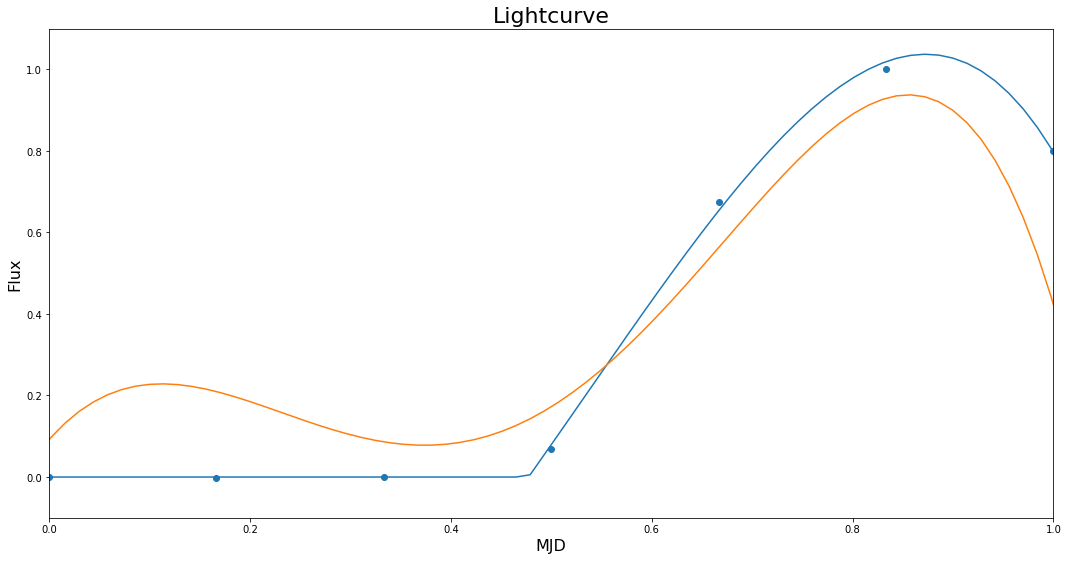

In [111]:
### BESTBAZ

from iminuit import Minuit
from iminuit.cost import LeastSquares


# iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
# We will revisit how to write this by hand in a later section.
least_squares = LeastSquares(mjd,flux,0.001,_bestbaz)

m = Minuit(least_squares, p1=guess_bestbaz[0],p2=guess_bestbaz[1],p3=guess_bestbaz[2],p4=guess_bestbaz[3],shift=guess_bestbaz[4])  # starting values for α and β

m.migrad()  # finds minimum of least_squares function

x_fit = np.linspace(mjd.min(),mjd.max(),500)

plt.figure(figsize=(18,9))
plt.scatter(mjd,flux)
plt.plot(x_fit,_bestbaz(x_fit,m.values[0],m.values[1],m.values[2],m.values[3],m.values[4]))
plt.plot(x_fit,_bestbaz(x_fit,*guess_bestbaz))


plt.title('Lightcurve',size = 22)
plt.xlabel('MJD',size = 16)
plt.ylabel('Flux',size = 16)
plt.ylim(-0.1,1.1)
plt.xlim(0,1)